In [125]:
import pandas as pd
import numpy as np
import itertools
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import glob
import copy

In [126]:
def get_case_values(sample, product_file, combinations_file, tfs, ctrls):
    
    #get case sample distances
    df = pd.read_parquet(product_file)
    df = df.query(f"TF in {tfs} & sample_1 == '{sample}' & sample_2 in {ctrls} ")
    gb = df.groupby('TF')    
    df_split_list = [gb.get_group(x) for x in gb.groups]
    sample_distances = [df.distance.to_numpy() for df in df_split_list]
    
    # get all ctrl distances compared to all other ctrls
    df = pd.read_parquet(combinations_file)
    df = df.query(f"TF in {tfs} & sample_1 in {ctrls} & sample_2 in {ctrls} ")
    gb = df.groupby('TF')    
    df_split_list = [gb.get_group(x) for x in gb.groups]
    ctrl_distances = [df.distance.to_numpy() for df in df_split_list]
    
    # two-sample Kolmogorov-Smirnov test
    D_stats = []
    distances = []
    ks_values = []
    for i in range(len(sample_distances)):
        data1 = sample_distances[i]
        data2 = ctrl_distances[i]
        D, p =stats.ks_2samp(data1, data2, alternative='less')
        ks_values.append(p)
        D_stats.append(D)
        distances.extend(data1)

    return ks_values, D_stats, distances

In [127]:
def get_ks_df(cases, samples, tfs, controls):
    
    ctrls = copy.deepcopy(controls)
    
    cases_D_stats = []
    cases_distances = []
    cases_p_values = []
    for i in range(len(cases)):
        product_file = f'./{cases[i]}/{cases[i]}_product.parquet'
        combinations_file = f'./{cases[i]}/{cases[i]}_combinations.parquet'
        sample = samples[i]
        p_values, D_stats, distances = get_case_values(sample, product_file, combinations_file, tfs, ctrls)
        cases_p_values.append(p_values)
        cases_D_stats.append(D_stats)
        cases_distances.append(distances)
        
    # CASE DATAFRAME
    p_df = pd.DataFrame(cases_p_values, columns=sorted(tfs))
    correction = len(tfs)
    p_df = p_df.mul(correction)
    p_df.index = samples
    p_df[p_df > 1] = 1
    
    D_df = pd.DataFrame(cases_D_stats, columns=sorted(tfs))
    D_df.index = samples
    
    
    #because of the remove in loop need list of ctrl both in & outside loop
    ctrls = copy.deepcopy(controls)
    
    indi_ctrl_distances = []
    for ctrl in ctrls:
        patient = 'OMD009'
        p_file = f'./{patient}/{patient}_product.parquet'
        df = pd.read_parquet(p_file)

        ctrls = copy.deepcopy(controls)
        ctrls.remove(ctrl)
        df = df.query(f"TF in {tfs} & sample_1 == '{ctrl}' & sample_2 in {ctrls}")
        gb = df.groupby('TF')    
        df_split_list = [gb.get_group(x) for x in gb.groups]
        sample_distances = [df.distance.to_numpy() for df in df_split_list]
        indi_ctrl_distances.append(sample_distances)
    
    #because of the remove in loop need list of ctrl both in & outside loop 
    ctrls = copy.deepcopy(controls) 
    
    other_ctrl_distances =  []
    for ctrl in ctrls:
        patient = cases[0]
        c_file = f'./{patient}/{patient}_combinations.parquet'
        df = pd.read_parquet(c_file)

        ctrls = copy.deepcopy(controls)
        ctrls.remove(ctrl)
        df = df.query(f"TF in {tfs} & sample_1 in {ctrls} & sample_2 in {ctrls} ")
        gb = df.groupby('TF')    
        df_split_list = [gb.get_group(x) for x in gb.groups]
        ctrl_distances = [df.distance.to_numpy() for df in df_split_list]
        other_ctrl_distances.append(ctrl_distances)

    ctrls = copy.deepcopy(controls)
    
    ctrl_D_stats = []
    ctrl_p_values = []
    for i in range(len(ctrls)):

        indi_D_stats = []
        indi_p_values =[]
        for j in range(len(tfs)):
            ctrl_distances = indi_ctrl_distances[i][j]
            other_distances = other_ctrl_distances[i][j]
            D, p = stats.ks_2samp(ctrl_distances, other_distances, alternative='less')
            indi_p_values.append(p)
            indi_D_stats.append(D)

        ctrl_p_values.append(indi_p_values)
        ctrl_D_stats.append(indi_D_stats)

        
    # CONTROL DATAFRAME
    ctrl_p_df = pd.DataFrame(ctrl_p_values, columns=sorted(tfs))
    correction = len(tfs)
    ctrl_p_df = ctrl_p_df.mul(correction)
    ctrl_p_df.index = ctrls
    ctrl_p_df[ctrl_p_df > 1] = 1
    
    ctrl_D_df = pd.DataFrame(ctrl_D_stats, columns=sorted(tfs))
    ctrl_D_df.index = ctrls
    
    p_df = pd.concat([p_df, ctrl_p_df])
    D_df = pd.concat([D_df, ctrl_D_df])
    
    return p_df, D_df

In [128]:
def group_ks(cases, samples, tfs, controls):
   
    ctrls = copy.deepcopy(controls)

    # for pairwise-group comparison
    HN_distances = []
    for i in range(len(HN_cases)):
        product_file = f'./{HN_cases[i]}/{HN_cases[i]}_product.parquet'
        combinations_file = f'./{HN_cases[i]}/{HN_cases[i]}_combinations.parquet'
        sample = HN_samples[i]
        ks_values, D_stats, distances = get_case_values(sample, product_file, combinations_file, tfs, ctrls)
        HN_distances.extend(distances)

    OMD_distances = []
    for i in range(len(OMD_cases)):
        product_file = f'./{OMD_cases[i]}/{OMD_cases[i]}_product.parquet'
        combinations_file = f'./{OMD_cases[i]}/{OMD_cases[i]}_combinations.parquet'
        sample = OMD_samples[i]
        ks_values, D_stats, distances = get_case_values(sample, product_file, combinations_file, tfs, ctrls)
        OMD_distances.extend(distances)


    PV_distances = []
    for i in range(len(PV_cases)):
        product_file = f'./{PV_cases[i]}/{PV_cases[i]}_product.parquet'
        combinations_file = f'./{PV_cases[i]}/{PV_cases[i]}_combinations.parquet'
        sample = PV_samples[i]
        ks_values, D_stats, distances = get_case_values(sample, product_file, combinations_file, tfs, ctrls)
        PV_distances.extend(distances)
        
    # KS test for CONTROLS AGAINST CONTROLS
    # get distances to compare one control to all OTHER CONTROLS 
    # returns 7 lists for each ctrl, each with 7 arrays for each TF - each array 6 distances

    #because of the remove in loop need list of ctrl both in & outside loop
    ctrls = copy.deepcopy(controls)

    indi_ctrl_distances = []
    for ctrl in ctrls:
        patient = cases[0]
        p_file = f'./{patient}/{patient}_product.parquet'
        df = pd.read_parquet(p_file)

        ctrls = copy.deepcopy(controls)
        ctrls.remove(ctrl)
        df = df.query(f"TF in {tfs} & sample_1 == '{ctrl}' & sample_2 in {ctrls}")
        gb = df.groupby('TF')    
        df_split_list = [gb.get_group(x) for x in gb.groups]
        sample_distances = [df.distance.to_numpy() for df in df_split_list]
        indi_ctrl_distances.append(sample_distances)

    #because of the remove in loop need list of ctrl both in & outside loop 
    ctrls = copy.deepcopy(controls) 

    other_ctrl_distances =  []
    for ctrl in ctrls:
        patient = 'OMD009'
        c_file = f'./{patient}/{patient}_combinations.parquet'
        df = pd.read_parquet(c_file)

        ctrls = copy.deepcopy(controls)
        ctrls.remove(ctrl)
        df = df.query(f"TF in {tfs} & sample_1 in {ctrls} & sample_2 in {ctrls} ")
        gb = df.groupby('TF')    
        df_split_list = [gb.get_group(x) for x in gb.groups]
        ctrl_distances = [df.distance.to_numpy() for df in df_split_list]
        other_ctrl_distances.append(ctrl_distances)


    ctrls = copy.deepcopy(controls)

    CTRL_distances = []
    for i in range(len(ctrls)):

        indi_dstances = []
        indi_ks_values =[]
        for j in range(len(tfs)):
            ctrl_distances = indi_ctrl_distances[i][j]
            other_distances = other_ctrl_distances[i][j]
            indi_dstances.extend(ctrl_distances)

        CTRL_distances.extend(indi_dstances)
    
    groups = ['HN', 'OMD', 'PV', 'CTRL']
    group_arrays = [HN_distances, OMD_distances, PV_distances, CTRL_distances]

    group_combos = list(itertools.combinations(groups, 2))
    group_array_combos = list(itertools.combinations(group_arrays, 2))

    compared_groups = []
    group_pvalues = []
    group_Dstats = []
    for i in range(len(group_combos)):
        paired_groups = list(group_combos[i])
        paired_arrays = group_array_combos[i]
        g1_array = paired_arrays[0]
        g2_array = paired_arrays[1]
        less = [['HN', 'CTRL'], ['OMD', 'CTRL'], ['PV', 'CTRL']]
        if paired_groups in less:
            D, p =stats.ks_2samp(g1_array, g2_array, alternative='less')
        else:
            D, p =stats.ks_2samp(g1_array, g2_array, alternative='greater')

        correction =  len(group_combos)
        adj_p = p * correction
        group_pvalues.append(p)
        group_Dstats.append(D)
        compared_groups.append(paired_groups)
    
    group_ks_lists = []
    for i in range(len(compared_groups)):
        group_ks_list = [compared_groups[i][0], compared_groups[i][1], group_Dstats[i], group_pvalues[i]]
        group_ks_lists.append(group_ks_list)
    
    group_ks_df = pd.DataFrame(group_ks_lists, columns = ['Group 1', 'Group 2', 'D Statistic', 'P-value'])
    
    return group_ks_df


In [129]:
in_directory = '/mnt/DATA1/Radiooncology'
HN_cases = ['HN001', 'HN002', 'HN003', 'HN004', 'HN005', 'HN006', 'HN007']
HN_BL_samples = []
HN_T1_samples = []
HN_T2_samples = []
HN_FU1_samples = []
HN_FU2_samples = []
for case in HN_cases:
    HN = sorted(glob.glob(in_directory + f"/{case}*", recursive=True))
    path = len('/mnt/DATA1/Radiooncology/')
    HN = [sample[path:] for sample in HN]
    HN_T1_samples.append(HN[-1])
    HN_T2_samples.append(HN[-2])
    HN_FU1_samples.append(HN[0])
    HN_FU2_samples.append(HN[1])
    HN_BL_samples.append(HN[2])

In [130]:
in_directory = '/mnt/DATA1/Radiooncology'
OMD_cases = ['OMD001', 'OMD004', 'OMD005', 'OMD006', 'OMD007', 'OMD008', 'OMD009']
OMD_BL_samples = []
OMD_T1_samples = []
OMD_T2_samples = []
OMD_FU1_samples = []
OMD_FU2_samples = []
for case in OMD_cases:
    OMD = sorted(glob.glob(in_directory + f"/{case}*", recursive=True))
    path = len('/mnt/DATA1/Radiooncology/')
    OMD = [sample[path:] for sample in OMD]
    OMD_T1_samples.append(OMD[-2])
    OMD_T2_samples.append(OMD[-1])
    OMD_FU1_samples.append(OMD[0])
    OMD_FU2_samples.append(OMD[1])
    OMD_BL_samples.append(OMD[2])
OMD_BL_samples.remove('OMD001_d2')
OMD_BL_samples  = ['OMD1_PreRT'] + OMD_BL_samples
OMD_T1_samples.remove('OMD008-d10')
OMD_T1_samples.insert(5, 'OMD008-d2')
OMD_T2_samples.remove('OMD008-d2') 
OMD_T2_samples.insert(5, 'OMD008-d10')

In [131]:
HN_cases = ['HN001', 'HN002', 'HN003', 'HN004', 'HN005', 'HN006', 'HN007']
OMD_cases = ['OMD001', 'OMD004', 'OMD005', 'OMD006', 'OMD007', 'OMD008', 'OMD009']
PV_cases = ['PV01', 'PV03', 'PV04_R1', 'PV05_R1', 'PV06_R1', 'PV07-BL', 'PV08-BL', 'PV09-BL']
cases = HN_cases + OMD_cases + PV_cases

controls = ['HV01', 'HV03', 'HV04', 'HV05', 'HV06', 'HV07', 'HV08']

tfs = ['BACH1', 'BACH2', 'BATF','IRF4', 'LYL1','SPI1', 'SPIB']

In [132]:
# BASELINE
HN_samples = HN_BL_samples
OMD_samples = OMD_BL_samples
PV_samples = ['PV01', 'PV03', 'PV04_R1', 'PV05_R1', 'PV06_R1', 'PV07-BL', 'PV08-BL', 'PV09-BL']

samples = HN_samples + OMD_samples + PV_samples

p_df, D_df = get_ks_df(cases, samples, tfs, controls)
group_ks_df = group_ks(cases, samples, tfs, controls)

In [133]:
group_ks_df

,Group 1,Group 2,D Statistic,P-value
0,HN,OMD,0.154519,2.718289e-04
1,HN,PV,0.291910,1.522483e-14
2,HN,CTRL,0.293489,8.014207e-13
3,OMD,PV,0.204446,1.790156e-07
4,OMD,CTRL,0.426628,1.127487e-26
5,PV,CTRL,0.556973,8.838014e-49


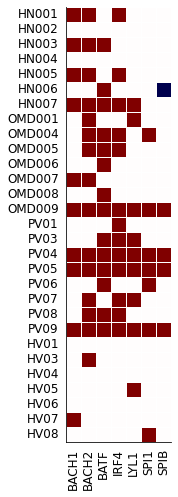

In [134]:
plot_df = p_df.applymap(lambda x: 0 if x > 0.01 else 1)
plot_df.at['HN006-BL', 'SPIB'] = -1
PV_short = ['PV01', 'PV03', 'PV04', 'PV05', 'PV06', 'PV07', 'PV08', 'PV09']
sample_names = HN_cases + OMD_cases + PV_short + controls
plt.figure(figsize=(12,8))
h = sns.heatmap(plot_df, linewidth = 1, cmap='seismic', square=True, yticklabels=sample_names, cbar=False)
h.tick_params(bottom=False, left=False, labelsize=12)
h.spines['left'].set_visible(True)
h.spines['bottom'].set_visible(True)
plt.savefig(f'heatmap_BL.png',dpi=300)

In [135]:
p_df

def bon_highlight(value):
    color = 'yellow' if value <= 0.01 else ''
    return 'background-color: {}'.format(color)

p_df.style.applymap(bon_highlight)

,BACH1,BACH2,BATF,IRF4,LYL1,SPI1,SPIB
HN001-BL,0.000816,0.000006,0.018569,0.007331,1.000000,1.000000,1.000000
HN002-Pre,0.554388,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
HN003-Pre,0.002654,0.000006,0.007331,1.000000,1.000000,1.000000,1.000000
HN004-BL,0.018569,1.000000,1.000000,1.000000,0.905719,1.000000,1.000000
HN005-BL,0.007331,0.000213,1.000000,0.000213,0.905719,1.000000,1.000000
HN006-BL,0.325353,0.018569,0.000006,1.000000,1.000000,1.000000,0.007331
HN007-BL,0.000213,0.000006,0.002654,0.000006,0.000047,0.554388,1.000000
OMD1_PreRT,0.325353,0.007331,1.000000,1.000000,0.000047,0.018569,1.000000
OMD004-BL,0.018569,0.000816,0.002654,0.007331,0.554388,0.002654,1.000000
OMD005-BL,0.325353,0.000816,0.000213,0.007331,0.905719,0.905719,1.000000


In [136]:
# T1
HN_samples = HN_T1_samples
OMD_samples = OMD_T1_samples
PV_cases = ['PV01', 'PV03', 'PV04_R1', 'PV05_R1', 'PV06_R1', 'PV07-BL', 'PV08-BL', 'PV09-BL']

samples = HN_samples + OMD_samples + PV_samples

p_df, D_df = get_ks_df(cases, samples, tfs, controls)
group_ks_df = group_ks(cases, samples, tfs, controls)

In [137]:
group_ks_df = group_ks_df.query('`Group 1` != "PV" &  `Group 2` != "PV"')
group_ks_df

,Group 1,Group 2,D Statistic,P-value
0,HN,OMD,0.288630,2.696960e-13
2,HN,CTRL,0.490768,1.973806e-35
4,OMD,CTRL,0.439261,2.752354e-28


In [138]:
p_df

def bon_highlight(value):
    color = 'yellow' if value <= 0.01 else ''
    return 'background-color: {}'.format(color)

p_df.style.applymap(bon_highlight)

,BACH1,BACH2,BATF,IRF4,LYL1,SPI1,SPIB
HN001-d8,0.018569,0.089690,1.000000,1.000000,0.018569,1.000000,1.000000
HN002-d8,0.000816,0.000213,0.007331,0.000213,1.000000,1.000000,1.000000
HN003-d8,0.000047,0.000213,0.000006,0.000006,0.000816,0.089690,1.000000
HN004-d8,0.000006,0.000006,0.042885,0.000006,0.000816,0.905719,0.554388
HN005-d8,0.000006,0.000213,0.000047,0.000213,1.000000,1.000000,1.000000
HN006-d8,0.000213,0.000006,0.000816,0.089690,1.000000,1.000000,1.000000
HN007-d8,0.000213,0.000006,0.000047,0.000006,0.905719,0.000213,0.018569
OMD001_d2,1.000000,1.000000,1.000000,1.000000,0.905719,1.000000,1.000000
OMD004-d2,0.554388,0.042885,0.002654,0.000213,1.000000,0.554388,1.000000
OMD005-d2,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


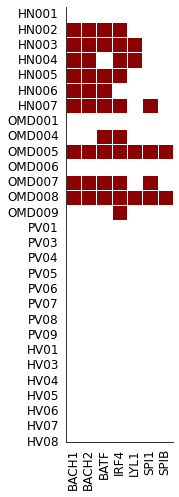

In [139]:
plot_df = p_df.applymap(lambda x: 0 if x > 0.01 else 1)
plot_df = plot_df.iloc[:14].T

cmap = LinearSegmentedColormap.from_list('mycmap', ['white', 'darkred'])
sample_names = HN_cases + OMD_cases + PV_short + controls
plot_df = plot_df.T
plt.figure(figsize=(12,8))
h = sns.heatmap(plot_df, linewidth = 1, cmap=cmap, square=True, yticklabels=sample_names, cbar=False)
h.tick_params(bottom=False, left=False, labelsize=12)
h.spines['left'].set_visible(True)
h.spines['bottom'].set_visible(True)
plt.savefig(f'heatmap_T1.png',dpi=300)

In [140]:
# T2
HN_samples = HN_T2_samples
OMD_samples = OMD_T2_samples
PV_cases = ['PV01', 'PV03', 'PV04_R1', 'PV05_R1', 'PV06_R1', 'PV07-BL', 'PV08-BL', 'PV09-BL']

samples = HN_samples + OMD_samples + PV_samples

p_df, D_df = get_ks_df(cases, samples, tfs, controls)
group_ks_df = group_ks(cases, samples, tfs, controls)

In [141]:
group_ks_df = group_ks_df.query('`Group 1` != "PV" &  `Group 2` != "PV"')
group_ks_df

,Group 1,Group 2,D Statistic,P-value
0,HN,OMD,0.212828,1.624726e-07
2,HN,CTRL,0.590865,3.945306e-52
4,OMD,CTRL,0.690962,4.291952e-73


In [142]:
p_df

def bon_highlight(value):
    color = 'yellow' if value <= 0.01 else ''
    return 'background-color: {}'.format(color)

p_df.style.applymap(bon_highlight)

,BACH1,BACH2,BATF,IRF4,LYL1,SPI1,SPIB
HN001-d49,0.000816,0.000006,0.000006,0.000047,1.000000,0.089690,0.905719
HN002-d49,0.000816,0.000006,0.042885,0.007331,0.000213,0.000213,0.000213
HN003-d49,0.018569,0.176910,0.000047,0.007331,0.000213,0.905719,1.000000
HN004-d43,0.000816,0.000047,0.000047,0.007331,0.905719,0.905719,1.000000
HN005-d43,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
HN006-D43,1.000000,0.018569,1.000000,1.000000,0.042885,1.000000,0.007331
HN007-d43,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
OMD001_d5,1.000000,0.325353,1.000000,1.000000,0.018569,1.000000,1.000000
OMD004-d5,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
OMD005-d5,0.000006,0.000006,0.042885,0.000006,0.000006,0.042885,0.000006


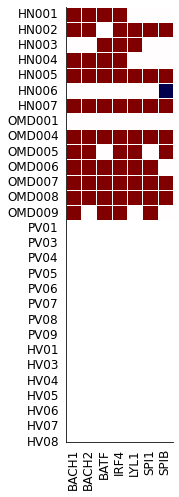

In [143]:
plot_df = p_df.applymap(lambda x: 0 if x > 0.01 else 1)
plot_df.at['HN006-D43', 'SPIB'] = -1
plot_df = plot_df.iloc[:14].T

sample_names = HN_cases + OMD_cases + PV_short + controls
plot_df = plot_df.T
plt.figure(figsize=(12,8))
h = sns.heatmap(plot_df, linewidth = 1, cmap='seismic', square=True, yticklabels=sample_names, cbar=False)
h.tick_params(bottom=False, left=False, labelsize=12)
h.spines['left'].set_visible(True)
h.spines['bottom'].set_visible(True)
plt.savefig(f'heatmap_T2.png',dpi=300)

In [144]:
# Follow-up 1
HN_samples = HN_FU1_samples
OMD_samples = OMD_FU1_samples
PV_cases = ['PV01', 'PV03', 'PV04_R1', 'PV05_R1', 'PV06_R1', 'PV07-BL', 'PV08-BL', 'PV09-BL']

samples = HN_samples + OMD_samples + PV_samples

p_df, D_df = get_ks_df(cases, samples, tfs, controls)
group_ks_df = group_ks(cases, samples, tfs, controls)

In [145]:
FU2 = HN_FU2_samples + OMD_FU2_samples
print(FU2)

['HN001-6m', 'HN002-6m', 'HN003-6m', 'HN004-6m', 'HN005-6m', 'HN006-6m', 'HN007-6m-2Eluat', 'OMD001-6m', 'OMD004-6m', 'OMD005-6m', 'OMD006-6m', 'OMD007-6m', 'OMD008-6m', 'OMD009-6m']


In [146]:
group_ks_df = group_ks_df.query('`Group 1` != "PV" &  `Group 2` != "PV"')
group_ks_df

,Group 1,Group 2,D Statistic,P-value
0,HN,OMD,0.005831,9.884226e-01
2,HN,CTRL,0.422741,3.446825e-26
4,OMD,CTRL,0.344995,1.610161e-17


In [147]:
p_df

def bon_highlight(value):
    color = 'yellow' if value <= 0.01 else ''
    return 'background-color: {}'.format(color)

p_df.style.applymap(bon_highlight)

,BACH1,BACH2,BATF,IRF4,LYL1,SPI1,SPIB
HN001-3m,0.000006,0.000006,0.000006,0.000006,0.000047,0.000213,0.554388
HN002-3m,0.018569,0.000006,0.325353,1.000000,1.000000,1.000000,1.000000
HN003-3m,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000213
HN004-3m,0.905719,0.089690,0.554388,1.000000,1.000000,1.000000,1.000000
HN005-3m,0.000213,0.000006,0.000213,0.000213,0.000816,0.089690,1.000000
HN006-3m,0.176910,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
HN007-3m,0.018569,0.000816,1.000000,1.000000,1.000000,0.905719,1.000000
OMD001-3m,0.000006,0.000213,0.000816,0.000006,0.000006,0.018569,1.000000
OMD004-3m,1.000000,1.000000,0.000816,1.000000,0.905719,0.905719,1.000000
OMD005-3m,0.007331,0.000006,0.007331,0.000006,1.000000,0.554388,0.000213


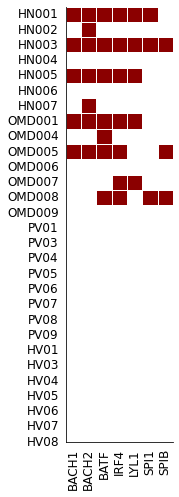

In [148]:
plot_df = p_df.applymap(lambda x: 0 if x > 0.01 else 1)
plot_df = plot_df.iloc[:14].T

cmap = LinearSegmentedColormap.from_list('mycmap', ['white', 'darkred'])
sample_names = HN_cases + OMD_cases + PV_short + controls
plot_df = plot_df.T
plt.figure(figsize=(12,8))
h = sns.heatmap(plot_df, linewidth = 1, cmap=cmap, square=True, yticklabels=sample_names, cbar=False)
h.tick_params(bottom=False, left=False, labelsize=12)
h.spines['left'].set_visible(True)
h.spines['bottom'].set_visible(True)
plt.savefig(f'heatmap_3m.png',dpi=300)

In [149]:
# Follow-up 2
HN_samples = HN_FU2_samples
OMD_samples = OMD_FU2_samples
PV_cases = ['PV01', 'PV03', 'PV04_R1', 'PV05_R1', 'PV06_R1', 'PV07-BL', 'PV08-BL', 'PV09-BL']

samples = HN_samples + OMD_samples + PV_samples

p_df, D_df = get_ks_df(cases, samples, tfs, controls)
group_ks_df = group_ks(cases, samples, tfs, controls)

In [150]:
group_ks_df = group_ks_df.query('`Group 1` != "PV" &  `Group 2` != "PV"')
group_ks_df

,Group 1,Group 2,D Statistic,P-value
0,HN,OMD,0.002915,9.970930e-01
2,HN,CTRL,0.503401,2.503720e-37
4,OMD,CTRL,0.304179,9.897369e-14


In [151]:
p_df

def bon_highlight(value):
    color = 'yellow' if value <= 0.01 else ''
    return 'background-color: {}'.format(color)

p_df.style.applymap(bon_highlight)

,BACH1,BACH2,BATF,IRF4,LYL1,SPI1,SPIB
HN001-6m,0.007331,0.002654,0.000047,0.002654,1.000000,1.000000,1.000000
HN002-6m,0.000006,0.000006,0.000006,0.000213,0.000006,0.000006,0.554388
HN003-6m,0.000006,0.000006,0.000006,0.000047,0.000006,0.018569,0.018569
HN004-6m,0.905719,0.000006,1.000000,1.000000,0.007331,1.000000,1.000000
HN005-6m,0.554388,0.554388,1.000000,1.000000,0.000213,1.000000,0.905719
HN006-6m,0.554388,1.000000,1.000000,0.018569,0.000006,0.002654,0.007331
HN007-6m-2Eluat,0.000047,0.000006,0.002654,0.000006,0.000006,0.042885,0.000213
OMD001-6m,0.018569,0.007331,0.000006,0.000006,1.000000,0.000047,0.042885
OMD004-6m,0.554388,0.000006,0.905719,1.000000,0.000047,1.000000,1.000000
OMD005-6m,1.000000,0.000006,0.000816,0.089690,0.000816,1.000000,1.000000


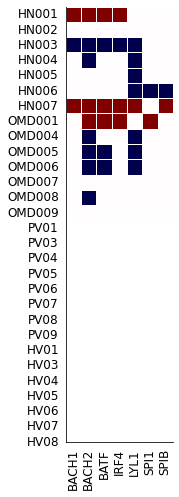

In [152]:
plot_df = p_df.applymap(lambda x: 0 if x > 0.01 else 1)
plot_df = plot_df.iloc[:14].T
plot_df["HN002-6m"] = 0 # drop-out

lower_coverage = ['HN003-6m', 'HN004-6m', 'HN005-6m', 'HN006-6m', 'OMD004-6m', 'OMD005-6m', 
                  'OMD006-6m', 'OMD008-6m']
for sample in lower_coverage:
    plot_df.loc[plot_df[sample] == 1, sample] = -1

sample_names = HN_cases + OMD_cases + PV_short + controls
plot_df = plot_df.T
plt.figure(figsize=(12,8))
h = sns.heatmap(plot_df, linewidth = 1, cmap='seismic', square=True, yticklabels=sample_names, cbar=False)
h.tick_params(bottom=False, left=False, labelsize=12)
h.spines['left'].set_visible(True)
h.spines['bottom'].set_visible(True)
plt.savefig(f'heatmap_6m.png',dpi=300)